This notebook is to visualize data and train models related to predicting IRBD via th Q10 questionarre developed by Dr. Emmanuel During @ Mount Sinai Hospital 

In [1]:
#if this does not load run the code below if 
#if in conda run: 'conda install..' 
#if in local run: 'pip install'
'''
! pip install matplotlin 
! pip install csv 
! pip install csv 
! pip intall numpy 
'''


import matplotlib.pyplot as plt
import os
import pandas as pd 
import numpy as np
from CQ10_plotting import plot_diagnosis_Qdata, plot_diagnosis_Qdata_nono 
import pycaret.classification as pc


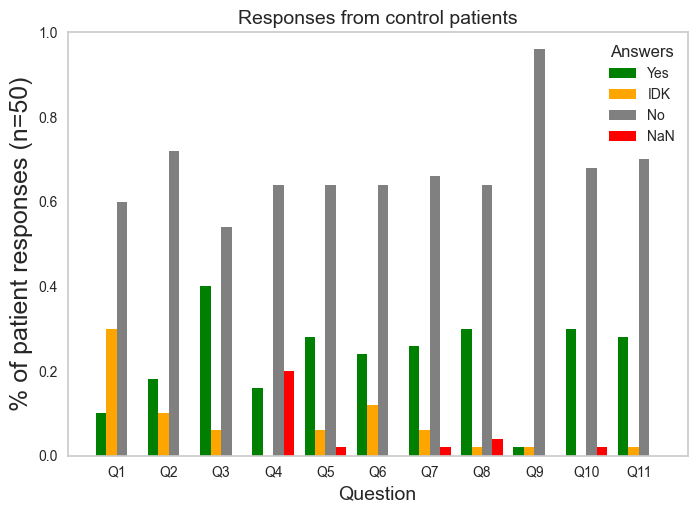

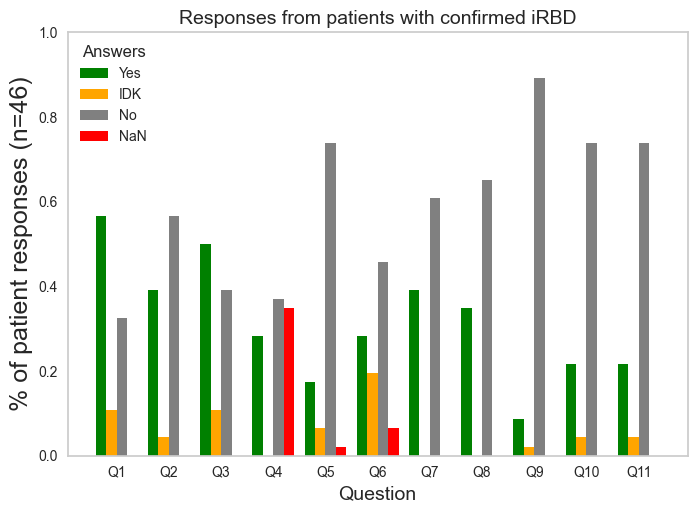

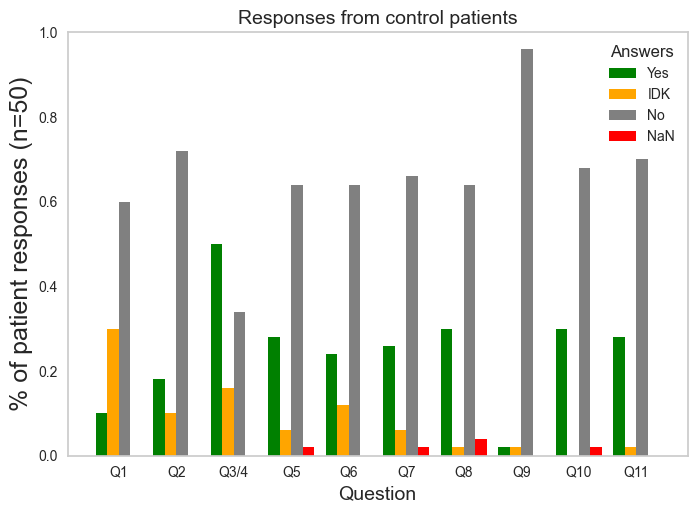

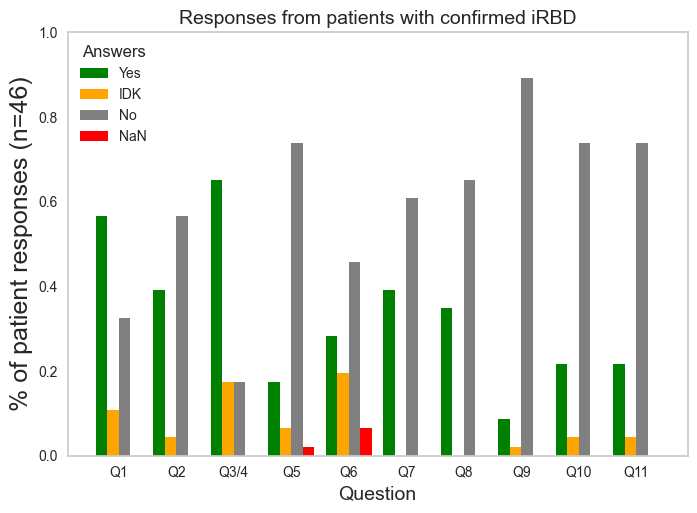

In [67]:
#load the csv files (clinical AND SHAS) shared by Salonee into a single pandas array 
clinic_df = pd.read_csv("CQ10 Excel(Clinic).csv")  
SHAS_df = pd.read_csv("CQ10 Excel(SHAS).csv")  
df = pd.concat([clinic_df, SHAS_df], ignore_index=True)


# Choose the columns relevant to our analysis
df = df.filter(items=['Diagnosis', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11'])
#make all text lowecase
df = df.map(lambda x: x.lower() if isinstance(x, str) else x)

# Filter out all non 'Control' or 'iRBD' diagnoses
df = df[df["Diagnosis"].isin(["control", "irbd"])].copy()

# One-hot encode diagnoses for iRBD = 1 and Control = 0
df = df.assign(Diagnosis=df["Diagnosis"].map({"irbd": 1, "control": 0}))

# Encode yes/no/idk answers 
Qs = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11']
for q in Qs: 
    df[q] = df[q].map({'yes':1, 'no':0, "don't know":0.5})

Qs = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11']
plot_diagnosis_Qdata(df, 0,  "Responses from control patients",Qs)
plot_diagnosis_Qdata(df, 1,  "Responses from patients with confirmed iRBD",Qs)

#combine Q3/Q4 and drop the OG dq3/4 columns, update the Qs for plotting
conditions = [
    (df['Q3']==0) & (df['Q4']==0), 
    ((df['Q3']==0.5) & (df['Q4']!=1)) | ((df['Q3']==0) & (df['Q4']!=1)), 
    (df['Q3']==1) | (df['Q4']==1) 
]
condition_values = [0,0.5,1]

df["Q3/Q4"] = np.select(conditions, condition_values, default=4433)
df = df.drop(columns=['Q3', 'Q4'])

#rearrange the order of the columns for Q3/Q4 to be in the right place
df = df[['Diagnosis','Q1', 'Q2', "Q3/Q4", 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11']]

#rearange things into order 
Qs = ['Q1', 'Q2', 'Q3/4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11']
plot_diagnosis_Qdata(df, 0,  "Responses from control patients",Qs, save=True, save_title="Q3Q4_control.jpg")
plot_diagnosis_Qdata(df, 1,  "Responses from patients with confirmed iRBD",Qs,save=True, save_title="Q3Q4_irbd.jpg")

In [31]:
'''
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df 
'''

"\npd.set_option('display.max_columns', None)\npd.set_option('display.max_rows', None)\ndf \n"

In [77]:
#calculate the sensitivity and specificity of the dara
control_df = df[df["Diagnosis"]==0].copy().drop("Diagnosis", axis=1)
irbd_df = df[df["Diagnosis"]==1].copy().drop("Diagnosis", axis=1)

#calculate sensitivity (tp/(tp+fn))
irbd_value_counts = irbd_df.apply(pd.Series.value_counts).fillna(0)
sensitivities = irbd_value_counts.loc[1]/irbd_df.shape[0]
print('sensitivities:\n',sensitivities)

#calculate selectivity(tn/(fp+tn))
control_value_counts = control_df.apply(pd.Series.value_counts).fillna(0)
selectivities = control_value_counts.loc[1]/control_df.shape[0]
print('selectivities:\n', selectivities) 

sensitivities:
 Q1       0.565217
Q2       0.391304
Q3/Q4    0.652174
Q5       0.173913
Q6       0.282609
Q7       0.391304
Q8       0.347826
Q9       0.086957
Q10      0.217391
Q11      0.217391
Name: 1.0, dtype: float64
selectivities:
 Q1       0.10
Q2       0.18
Q3/Q4    0.50
Q5       0.28
Q6       0.24
Q7       0.26
Q8       0.30
Q9       0.02
Q10      0.30
Q11      0.28
Name: 1.0, dtype: float64


In [92]:
df_value_counts = df.apply(pd.Series.value_counts).fillna(0)
df_value_counts/df.shape[0]

,Diagnosis,Q1,Q2,Q3/Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11
0.0,0.520833,0.468750,0.645833,0.260417,0.687500,0.552083,0.635417,0.645833,0.927083,0.708333,0.71875
0.5,0.000000,0.208333,0.072917,0.166667,0.062500,0.156250,0.031250,0.010417,0.020833,0.020833,0.03125
1.0,0.479167,0.322917,0.281250,0.572917,0.229167,0.260417,0.322917,0.322917,0.052083,0.260417,0.25000


Now, before proceding to work on any models we plot the responses of people in the control and iRBD groups

In [12]:
#plot_diagnosis_Qdata(df, 0,  "Responses from control patients","NoQ4nan_p_control_qs.jpg")
#plot_diagnosis_Qdata(df, 1,  "Responses from patients with confirmed iRBD","NoQ4nan_p_iRBD_qs.jpg")



In [15]:
'''
need to update the nono to handle different q values and the save toggle
'''
#plot_diagnosis_Qdata_nono(df, 0,  "Responses from control patients","no_No_NoQ4nan_p_control_qs.jpg")
#plot_diagnosis_Qdata_nono(df, 1,  "Responses from patients with confirmed iRBD","noNO_NoQ4nan_p_iRBD_qs.jpg")

'\nneed to update the nono to handle different q values and the save toggle\n'

In [93]:
pc.setup(data=df, target = 'Diagnosis', train_size=0.95)
best_models = pc.compare_models()

,Description,Value
0,Session id,1086
1,Target,Diagnosis
2,Target type,Binary
3,Original data shape,"(96, 11)"
4,Transformed data shape,"(96, 11)"
5,Transformed train set shape,"(91, 11)"
6,Transformed test set shape,"(5, 11)"
7,Numeric features,10
8,Rows with missing values,8.3%
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.7256,0.7370,0.6900,0.7267,0.6955,0.4380,0.4519,0.0080
lda,Linear Discriminant Analysis,0.7156,0.7370,0.6500,0.6883,0.6605,0.4142,0.4163,0.0040
ridge,Ridge Classifier,0.7044,0.7420,0.6250,0.6883,0.6415,0.3899,0.3970,0.0040
lightgbm,Light Gradient Boosting Machine,0.7033,0.7610,0.6450,0.6600,0.6459,0.3881,0.3880,0.0570
nb,Naive Bayes,0.6922,0.7470,0.5350,0.7000,0.5851,0.3662,0.3809,0.0700
lr,Logistic Regression,0.6822,0.7570,0.6050,0.6883,0.6276,0.3496,0.3648,0.2200
qda,Quadratic Discriminant Analysis,0.6600,0.6240,0.5700,0.6967,0.5913,0.3172,0.3410,0.0030
dt,Decision Tree Classifier,0.6389,0.6100,0.5800,0.6467,0.5979,0.2680,0.2725,0.0030
knn,K Neighbors Classifier,0.6344,0.6165,0.5300,0.5433,0.5316,0.2441,0.2330,0.0750
rf,Random Forest Classifier,0.6256,0.6200,0.5050,0.6250,0.5514,0.2344,0.2376,0.0170


In [22]:
lgbm_w_pp = pc.create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6000,0.6000,0.6000,0.6000,0.6000,0.2000,0.2000
1,0.6667,0.7000,0.5000,0.6667,0.5714,0.3077,0.3162
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,0.7778,0.7000,0.7500,0.7500,0.7500,0.5500,0.5500
6,0.7778,0.8000,0.7500,0.7500,0.7500,0.5500,0.5500
7,0.5556,0.6000,0.2000,1.0000,0.3333,0.1818,0.3162
8,0.5556,0.6500,0.6000,0.6000,0.6000,0.1000,0.1000


In [ ]:
auc_lgbm_w_pp = pc.tune_model(lgbm_w_pp ,n_iter=10000, optimize='auc', choose_better=True, search_library='optuna' ,search_algorithm='tpe')


In [17]:
pc.setup(data=df, target = 'Diagnosis',fold=10,train_size=0.95, preprocess=False,session_id=43)
best_models = pc.compare_models()

,Description,Value
0,Session id,43
1,Target,Diagnosis
2,Target type,Binary
3,Original data shape,"(96, 11)"
4,Transformed data shape,"(96, 11)"
5,Transformed train set shape,"(91, 11)"
6,Transformed test set shape,"(5, 11)"
7,Numeric features,10
8,Rows with missing values,8.3%


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7133,0.7660,0.6450,0.7967,0.6746,0.4245,0.4567,0.0530
rf,Random Forest Classifier,0.6156,0.6670,0.5550,0.6279,0.5762,0.2231,0.2213,0.0150
dt,Decision Tree Classifier,0.6056,0.5910,0.6200,0.5945,0.5980,0.1990,0.2012,0.0030
dummy,Dummy Classifier,0.5167,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0030


In [ ]:
rf = pc.create_model('rf')
mae_rf_opt = pc.tune_model(rf ,n_iter=10000, choose_better=True, search_library='optuna' ,search_algorithm='tpe')
